<a href="https://colab.research.google.com/github/rudraxx/pytorch/blob/main/Vision_Transformer_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer (ViT)

I will be implementing the Vision Transformer network from scratch. We will train the network on CIFAR-10 data.

Link to the original Paper:


1.   [Attention is All you need](https://arxiv.org/pdf/1706.03762)
2.   [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale
](https://arxiv.org/abs/2010.11929)



Articles used as reference:


1.   [Article on Medium](https://towardsdatascience.com/implementing-vision-transformer-vit-from-scratch-3e192c6155f0)
2.   List item



Overview of the VIT Architecture
![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Q-mBZkDz7TUnVGw1KPwqOA.png)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.optim as optim


import math


In [2]:
#Set up some of the hyper parameters

#Load the config
config ={"image_size": 128, "patch_size": 16,
         "num_channels":3, "hidden_size": 16,
         "hidden_dropout_prob": 0.2,
         "num_attention_heads":4,
         "qkv_bias": False,
         "attention_probs_dropout_prob": 0.2,
         "hidden_dropout_prob": 0.2,
         "intermediate_size": 8,
         "num_hidden_layers": 2}


In [3]:
# Set the device type

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")


Selected device: cuda


**Stages of the model pipeline**
1. Convert images into patches
2. Run the patches through linear layer to get patch embeddings. Layer weights are learnt.
3. Add the CLS token as the first token for all instances in the batch
3.  Get positional embeddings( sin/cos transform)
4. Input to the transformer is the sum of patch and positional embeddings



In [4]:
#Convert images into patches
class PatchEmbeddings(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.image_size   = config["image_size"] # Size of the incoming images ih xiw
    self.patch_size   = config["patch_size"] # What is the size of the patch hxw
    self.num_channels = config["num_channels"] # ch
    self.hidden_size  = config["hidden_size"] # d_hidden

    #Calculate the number of patches from the image and patch size
    self.num_patches = (self.image_size // self.patch_size)**2 # p x p

    #Create the projection to convert the images into patches
    # This layer should take each patch and convert it into a 1D vector of size (1, d_hidden)
    self.projection = nn.Conv2d(self.num_channels, self.hidden_size,
                                kernel_size=self.patch_size,
                                stride=self.patch_size)


  def forward(self, x):

    # x is of shape: (B X num_channels X image_size X image_size)
    # Required output is of shape: (B X num_patches X d_hidden)

    #1) (B X num_channels X image_size X image_size) -> (B X d_hidden X self.num_patches X self.num_patches)
    x = self.projection(x)
    #2) (B X d_hidden X self.num_patches X self.num_patches) -> (B X d_hidden X self.num_patches*self.num_patches)
    x = x.flatten(2)
    #3) (B X d_hidden X self.num_patches*self.num_patches) -> (B X self.num_patches*self.num_patches X d_hidden)
    x=x.transpose(1,2)

    return x



In [5]:
#Test out the patch embeddings class
x = torch.randn(32,config["num_channels"], config["image_size"], config["image_size"])
print(f"Input tensor shape to the patch embedding model: \n {x.shape}. (B X num_channels X image_size X image_size)")


patch_embedding = PatchEmbeddings(config)

x = patch_embedding(x)
print(f"After the patch embedding:\n {x.shape}. (B X num_patches X d_hidden)")



Input tensor shape to the patch embedding model: 
 torch.Size([32, 3, 128, 128]). (B X num_channels X image_size X image_size)
After the patch embedding:
 torch.Size([32, 64, 16]). (B X num_patches X d_hidden)


In [6]:
# Add the CLS token to the beginning of each sequence
class Embeddings(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.patch_embeddings = PatchEmbeddings(config)

    #Create a learnable [CLS] token. This is added before the first patch,
    # so should be the same dimension of the other patches
    self.cls_token = nn.Parameter(torch.randn(1, config["hidden_size"]))

    # Position embedding is added(summed up) with the B X CLS+num_patches X d_hidden,
    # so ensure the shape of position_embedding takes this into account
    self.position_embeddings = \
      nn.Parameter(torch.randn(1,self.patch_embeddings.num_patches + 1, config["hidden_size"]))

    # Drop out layer
    self.dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, x):

    batch_size = x.shape[0]
    #Get the patch embeddings
    x = self.patch_embeddings(x)

    #Add the CLS token to every batch item
    cls_tokens = self.cls_token.unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (B, 1, d_hidden)
    # Concat the cls token. Note that the size of the hidden_size stays the same. The number of patches/tokens increases by 1.
    # because CLS is added as the first token.
    x = torch.cat((cls_tokens, x), dim=1)

    #Add positional embedding
    x = x + self.position_embeddings

    # Dropout
    x = self.dropout(x)

    return x


In [7]:
#Test code to try the math for addition of the cls to the batch
cls_x1 = torch.randn(1,10)
print("cls_x1", cls_x1.shape)

expanded_cls = cls_x1.unsqueeze(0).repeat(32,1,1)
print("expanded_cls", expanded_cls.shape)

x = torch.randn(32,200, 10)
print("x", x.shape)

cat_result = torch.cat((expanded_cls, x), dim=1)
print("cat_result", cat_result.shape)



cls_x1 torch.Size([1, 10])
expanded_cls torch.Size([32, 1, 10])
x torch.Size([32, 200, 10])
cat_result torch.Size([32, 201, 10])


In [8]:
#Test out the embeddings
embeddings = Embeddings(config)
print(embeddings)


Embeddings(
  (patch_embeddings): PatchEmbeddings(
    (projection): Conv2d(3, 16, kernel_size=(16, 16), stride=(16, 16))
  )
  (dropout): Dropout(p=0.2, inplace=False)
)


The CLS + Position + Patch embeddings have been created. Next step is to create the Transformer Encoder model

# Multi-head Attention Module

The Attention module takes sequence of embeddings as input and computes query, key and value vectors for each embedding

In [9]:
class AttentionHead(nn.Module):
  """
  A single attention head
  Used in MultiAttentionHead module

  """

  def __init__(self, hidden_size, attention_head_size, prob_dropout, bias=True):
    super().__init__()

    self.hidden_size = hidden_size
    self.attention_head_size = attention_head_size

    #Create the query, key and value projection layers
    self.query  = nn.Linear(hidden_size, attention_head_size, bias=bias)
    self.key    = nn.Linear(hidden_size, attention_head_size, bias=bias)
    self.value  = nn.Linear(hidden_size, attention_head_size, bias=bias)

    self.dropout = nn.Dropout(prob_dropout)

  def forward(self, x):
    # Shape of x: (B x 1+num_patches x hidden_size)
    #Project the input into query, key, value
    # Since the same x vector is used to generate the Q,K,V values,
    # this is called self-attention
    query = self.query(x) # (B x 1+num_patches x attention_head_size)
    key   = self.key(x)   # (B x 1+num_patches x attention_head_size)
    value = self.value(x) # (B x 1+num_patches x attention_head_size)

    #Calculate the attention scores
    # softmax(Q*K.T/sqrt(head_size)) *V
    # print("query.shape", query.shape)
    # print("key.shape", key.shape)
    # print("value.shape", value.shape)

    attention_scores = query @ key.transpose(-1,-2) # Q*K.T
    attention_scores = attention_scores/self.attention_head_size**0.5 # Q*K.T/sqrt(d_head)
    # print("attention_score for 0th item, 0th token pre softmax:", attention_scores[0,0,:])

    #For every token( dim=1), get the softmax across all the other tokens.
    # At this stage the dims are B X 1+num_patches X 1+num_patches.
    # Take the softmax across the last dim, because each entry in dim=1
    # represents the score wrt all the other tokens
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    # print("attention_score for 0th item, 0th token post softmax:", attention_scores[0,0,:])
    # print("sum of attention_score for 0th item, 0th token post softmax:", torch.sum(attention_scores[0,0,:]))

    # Dropout
    attention_probs = self.dropout(attention_probs)

    #Now the scores are of the size: B X 1+num_patches X 1+num_patches,
    # and they represent the relative weight for other tokens. Multiply this
    # to the value matrix to get the update
    attention_output = attention_probs@value
    # print("attention_scores.shape", attention_scores.shape)

    return (attention_output, attention_probs)


# Test
hidden_size= config["hidden_size"]#14
print(hidden_size)

attention_head_size = config["hidden_size"] // config["num_attention_heads"]
# attention = AttentionHead(, ,
#                           prob_dropout=0.2)

attention = AttentionHead(hidden_size, attention_head_size,
                          prob_dropout=0.2)

x = torch.randn(32, 65, hidden_size)
print(f"hidden_size={hidden_size}")
print(f"Input shape: {x.shape}")
print(f"attention_head_size={attention_head_size}")
(attention_output, attention_probs) = attention(x)

print(f"Output attention_output.shape = {attention_output.shape}, attention_probs: {attention_probs.shape}")

16
hidden_size=16
Input shape: torch.Size([32, 65, 16])
attention_head_size=4
Output attention_output.shape = torch.Size([32, 65, 4]), attention_probs: torch.Size([32, 65, 65])


In [10]:
config["hidden_size"]

16

In [11]:
class MultiHeadAttention(nn.Module):
  """
  Multi-haed attention module.
  Used in Transformer Encoder module
  """
  def __init__(self, config):
    super().__init__()
    self.hidden_size = config["hidden_size"]
    self.num_attention_heads = config["num_attention_heads"]
    # The attention head size is the hidden size divided by the number of attention heads
    self.attention_head_size = self.hidden_size//self.num_attention_heads

    #Recalculate the total size of head. If the hidden size is not a integer
    # multiple of num_attention_heads, the all_head_size value can be different
    # than self.hidden_size
    self.all_head_size = self.attention_head_size * self.num_attention_heads

    # Decide if bias is used in the Q,K,V projection layers
    self.qkv_bias = config["qkv_bias"]

    #Create the list of attention heads
    self.heads = nn.ModuleList([])

    for _ in range(self.num_attention_heads):
      head = AttentionHead(self.hidden_size, self.attention_head_size,
                           config["attention_probs_dropout_prob"], self.qkv_bias)
      self.heads.append(head)

    #Create a linear layer to project the attention output back to the hidden size
    self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
    self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, x, output_attentions=False):
    # print(x.shape)
    # Calculate the attention output for each attention head
    attention_result = [head(x) for head in self.heads]

    #Concat the results along the last dim. Recombine to get back the "hidden_size" in last dim
    attention_output = torch.cat([attention_outputs for (attention_outputs, _) in attention_result], dim=-1)

    #Project the concatenated attention output back to hidden_size
    attention_output = self.output_projection(attention_output)
    attention_output = self.output_dropout(attention_output)

    #Return the attention output and probabilities if needed
    if not output_attentions:
      return (attention_output, None)
    else:
      attention_probs = torch.cat([attention_prob for (_, attention_prob) in attention_result], dim=1)
      return (attention_output, attention_probs)



# Test
mha = MultiHeadAttention(config)

# # Test
# attention = AttentionHead(config["hidden_size"], config["attention_head_size"],
#                           prob_dropout=0.2)

x = torch.randn(32, 65, config["hidden_size"])
print(f"hidden_size={hidden_size}")
print(f"Input shape: {x.shape}")
print(f"attention_head_size={attention_head_size}")
attention_output, attention_probs = mha(x, output_attentions=True)

print(f"Output attention_output.shape = {attention_output.shape}, attention_probs: {attention_probs.shape}")

hidden_size=16
Input shape: torch.Size([32, 65, 16])
attention_head_size=4
Output attention_output.shape = torch.Size([32, 65, 16]), attention_probs: torch.Size([32, 260, 65])


# Transformer Encoder

![Encoder structure](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*iHJ8nTDR1CpOSb-o.png)

In [12]:
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """

    def forward(self, input):
        return (
            0.5
            * input
            * (
                1.0
                + torch.tanh(
                    math.sqrt(2.0 / math.pi)
                    * (input + 0.044715 * torch.pow(input, 3.0))
                )
            )
        )


class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.dense_1 = nn.Linear(config["hidden_size"], config['intermediate_size'])
    self.activation = NewGELUActivation()
    self.dense_2 = nn.Linear(config['intermediate_size'], config["hidden_size"])
    self.dropout = nn.Dropout(config["hidden_dropout_prob"])

  def forward(self, x):
    x = self.dense_1(x)
    x = self.activation(x)
    x = self.dense_2(x)
    x = self.dropout(x)

    return x




In [13]:
class Block(nn.Module):
  '''
  A single transformer block
  '''

  def __init__(self, config):
    super().__init__()
    self.attention = MultiHeadAttention(config)

    self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
    self.mlp = MLP(config)
    self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

  def forward(self, x, output_attentions=False):
    xres_1 = x # Keep track for skip connection
    x = self.layernorm_1(xres_1)
    # Self attention
    (attention_output, attention_probs) = self.attention(x, output_attentions=output_attentions)

    #Add the first skip connection
    xres_2 = attention_output + xres_1 # Add the skip connection
    x = self.layernorm_1(xres_2)

    #FF Network
    x = self.mlp(x)

    #Add the second skip connection
    x = x + xres_2

    # Return the output and attention probs if asked for:

    if output_attentions:
      return (x, attention_probs)
    else:
      return (x, None)



In [14]:
# The transformer encoder stacks multiple Blocks on top of each other

class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.blocks = nn.ModuleList([])
    for _ in range(config["num_hidden_layers"]):
      self.blocks.append(Block(config))

  def forward(self, x, output_attentions=False):

    #Calculate the transformer block's output for each block
    all_attentions = []
    for block in self.blocks:
      x, attention_probs = block(x, output_attentions)
      if output_attentions:
        all_attentions.append(attention_probs)
    # Return the encoder's output and the attention probabilities

    if output_attentions:
      return (x, all_attentions)
    else:
      return (x, None)




# ViT for image classification

In [15]:
class ViTClassification(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.config = config
    self.image_size = config["image_size"]
    self.hidden_size = config["hidden_size"]
    self.num_classes = config["num_classes"]


    #Create the embedding model
    self.embeddings = Embeddings(config)

    #Encoder
    self.encoder = Encoder(config)

    #Linear layer to project the encoder's output to number of classes
    self.mlp_final = nn.Linear(self.hidden_size, self.num_classes) #(B x 1+num_patches x hidden_size)

    #Initialize the weights
    # self.apply(self._init_weights)

  def forward(self, x, output_attentions=False):

    # Get the embeddings for the imput
    x = self.embeddings(x)

    #Encoded values
    (encoder_output, all_attentions) = self.encoder(x, output_attentions)

    # Calculate the logits, take the [CLS] tokens output as the feature vector for the final classification MLP
    logits = self.mlp_final(encoder_output[:,0])

    #Return the logits and attention probs
    if output_attentions:
      return (logits, all_attentions)
    else:
      return (logits, None)




In [16]:
#Test the full model
x = torch.randn(12, 3, 32,32)
config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

model = ViTClassification(config)

logits, attention_probs = model(x, output_attentions=False)

print(logits.shape)


torch.Size([12, 10])


# CIFAR10 dataset

In [17]:

# Hyperparams
BATCH_SIZE=128
EPOCHS = 100
LR = 1e-3


# Apply the transform while extracting the data.
train_transform = transforms.Compose(transforms=
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.75, 1.333), interpolation=2),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

test_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Resize((32,32)),
     torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

ds_train = torchvision.datasets.CIFAR10(root="./data", train=True,
                            download=True, transform=train_transform)

#Split into train and validation
ds_train, ds_val = torch.utils.data.random_split(ds_train,[0.8, 0.2])


ds_test = torchvision.datasets.CIFAR10(root="./data", train=False,
                            download=True, transform=test_transform)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

labels_dict = {i: curr_class for i,curr_class in enumerate(ds_train.dataset.classes)}
print(labels_dict)

100%|██████████| 170498071/170498071 [00:19<00:00, 8615714.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


tensor(-1.) tensor(1.) torch.Size([128, 3, 32, 32])
['frog', 'frog', 'automobile', 'truck', 'automobile', 'bird', 'deer', 'frog', 'ship', 'automobile', 'airplane', 'bird', 'deer', 'dog', 'deer', 'cat', 'deer', 'airplane', 'cat', 'cat', 'cat', 'automobile', 'frog', 'truck', 'dog', 'cat', 'cat', 'automobile', 'dog', 'bird', 'deer', 'cat', 'cat', 'automobile', 'automobile', 'airplane', 'automobile', 'deer', 'airplane', 'automobile', 'truck', 'cat', 'frog', 'frog', 'dog', 'automobile', 'dog', 'airplane', 'bird', 'airplane', 'frog', 'dog', 'frog', 'dog', 'deer', 'cat', 'frog', 'bird', 'truck', 'automobile', 'bird', 'deer', 'dog', 'ship', 'ship', 'horse', 'frog', 'frog', 'ship', 'truck', 'truck', 'bird', 'automobile', 'horse', 'ship', 'cat', 'ship', 'deer', 'bird', 'deer', 'dog', 'automobile', 'dog', 'dog', 'frog', 'horse', 'cat', 'deer', 'dog', 'horse', 'ship', 'dog', 'airplane', 'horse', 'deer', 'deer', 'deer', 'airplane', 'automobile', 'cat', 'airplane', 'deer', 'ship', 'horse', 'cat', 'a

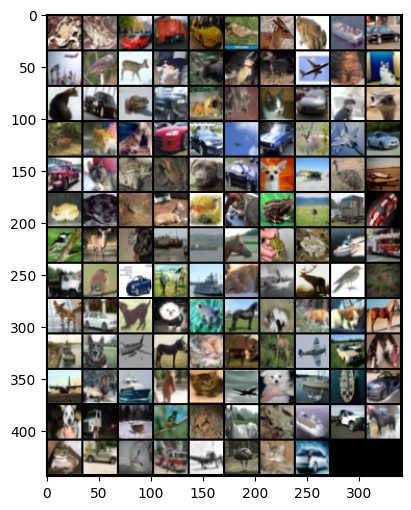

In [18]:
#Show some images
import matplotlib.pyplot as plt

images, labels = next(iter(dl_train))
print(torch.min(images), torch.max(images), images.shape)

plt.figure(figsize=(8,6))
plt.imshow(torchvision.utils.make_grid(images/2+0.5,nrow=10).permute(1,2,0))
print([labels_dict[x] for x in labels.tolist()])



In [19]:
# Set the loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LR)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

#Move the model to the device
model.to(device)

ViTClassification(
  (embeddings): Embeddings(
    (patch_embeddings): PatchEmbeddings(
      (projection): Conv2d(3, 48, kernel_size=(4, 4), stride=(4, 4))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-3): 4 x Block(
        (attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x AttentionHead(
              (query): Linear(in_features=48, out_features=12, bias=True)
              (key): Linear(in_features=48, out_features=12, bias=True)
              (value): Linear(in_features=48, out_features=12, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (output_projection): Linear(in_features=48, out_features=48, bias=True)
          (output_dropout): Dropout(p=0.0, inplace=False)
        )
        (layernorm_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (dense_1): Linear(in_features=48, out_features=19

In [20]:
#Training
# Start the training loop
array_training_loss = []
array_val_loss = []
for epoch in range(EPOCHS):

  running_training_loss = 0

  #Set model in train mode
  model.train()
  for data, labels in dl_train:

    data = data.to(device)
    labels = labels.to(device)

    logits, attention_probs = model(data, output_attentions=False)

    loss = criterion(logits,labels)

    # Zero the gradient
    optimizer.zero_grad()

    # calculate the gradients
    loss.backward()

    # Apply the update
    optimizer.step()

    running_training_loss += loss.cpu().item()

  epoch_training_loss = running_training_loss/len(dl_train)

  array_training_loss.append(epoch_training_loss)

  # Get the validation loss

  #Set model in eval mode
  model.eval()

  with torch.no_grad():
    running_val_loss = 0

    for data, labels in dl_val:
      data = data.to(device)
      labels = labels.to(device)

      # out = model(data)
      logits, attention_probs = model(data, output_attentions=False)

      loss = criterion(logits,labels)
      running_val_loss += loss.cpu().item()

  epoch_val_loss = running_val_loss/len(dl_val)

  array_val_loss.append(epoch_val_loss)



  print(f"EPOCH {epoch}/{EPOCHS}: training_loss = {epoch_training_loss}, val_loss = {epoch_val_loss}")

print('Finished Training')

EPOCH 0/100: training_loss = 1.8810949317944317, val_loss = 1.6790427301503434
EPOCH 1/100: training_loss = 1.5695354957550098, val_loss = 1.5157942258858983
EPOCH 2/100: training_loss = 1.4429385867743447, val_loss = 1.3912271608280231
EPOCH 3/100: training_loss = 1.3727120164865123, val_loss = 1.3860856883133514
EPOCH 4/100: training_loss = 1.3179413754338274, val_loss = 1.3184997462019135
EPOCH 5/100: training_loss = 1.2731425720281875, val_loss = 1.289195265951036
EPOCH 6/100: training_loss = 1.2393423046547765, val_loss = 1.2553915630413006
EPOCH 7/100: training_loss = 1.2014317891468256, val_loss = 1.2455956513368631
EPOCH 8/100: training_loss = 1.1831167184125881, val_loss = 1.2152750431736814
EPOCH 9/100: training_loss = 1.148341163469199, val_loss = 1.2066815910460074
EPOCH 10/100: training_loss = 1.1272309807161935, val_loss = 1.1800548230545431
EPOCH 11/100: training_loss = 1.1037230927723285, val_loss = 1.1427343646182289
EPOCH 12/100: training_loss = 1.0819570759233956, va

KeyboardInterrupt: 

In [21]:
# Get training accuracy
#Set model in eval mode
model.eval()

correct_samples = 0.0
total_samples = 0.0

with torch.no_grad():
  for data, labels in dl_test:
    data = data.to(device)
    labels = labels.to(device)

    logits, attention_probs = model(data, output_attentions=False)

    predicted_label = torch.argmax(logits,axis=1)

    correct_samples += torch.sum(predicted_label==labels)
    total_samples += labels.size(0)


print(f"Accuracy on test set = {100.0*correct_samples/total_samples :.2f}%")


Accuracy on test set = 67.65%


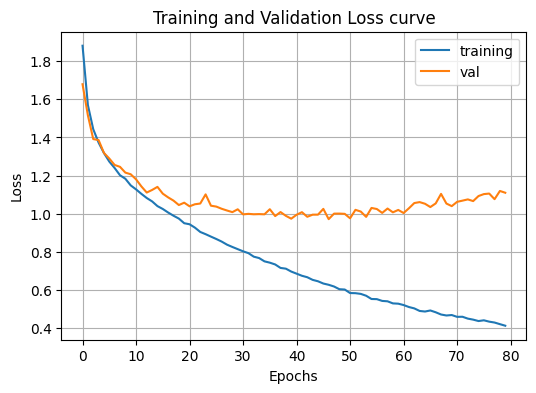

In [24]:
#Plot the loss curves
import numpy as np

plt.figure(figsize=(6,4))
EPOCHS = 80
plt.plot(np.arange(0,EPOCHS), array_training_loss, label="training")
plt.plot(np.arange(EPOCHS), array_val_loss, label="val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss curve")
plt.grid('on')
plt.legend()

plt.show()

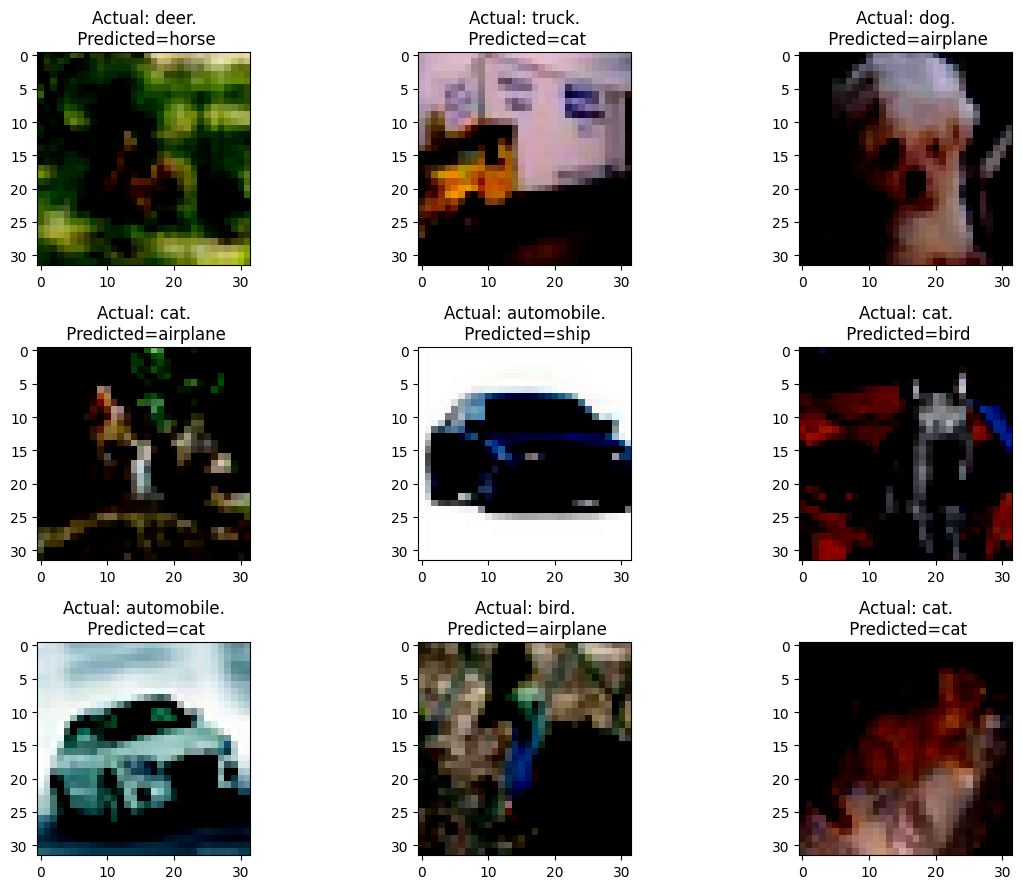

In [25]:
# Show a few predictions

dl_example = DataLoader(ds_test,batch_size=9,shuffle=True)

images, labels = next(iter(dl_example))

# print(images.shape[0])
#Predict
import matplotlib.gridspec as gridspec

pred_labels, attention_probs = model(data.to(device), output_attentions=False)

pred_labels = torch.argmax(pred_labels,axis=1)

rows=3
cols=3

figure = plt.figure(figsize=(12,9))
# figure, axes = plt.subplots(3, 3, figsize=(8, 8))

for idx in range(images.shape[0]):

  image = images[idx]
  label = labels[idx].item()
  pred_label = pred_labels[idx].item()
  # print(label, pred_label)

  figure.add_subplot(rows, cols, idx+1)
  plt.imshow(image.permute(1,2,0), cmap='gray')
  plt.title(f"Actual: {labels_dict[label]}.\n Predicted={labels_dict[pred_label]}")

plt.tight_layout()